In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from util.TSB_AD.metrics import metricor
from util.TSB_AD.slidingWindows import find_length #,plotFig, printResult
from sklearn.preprocessing import MinMaxScaler
import os
import sys
import copy

from util.plot_aadd import *
from util.util_a2d2 import *
from util.util_exp import *

# from scipy.io import arff
import arff

# from tqdm.notebook import tqdm
import time
import math
from util.TranAD_base import *
from util.TSB_AD.models.norma import NORMA
from util.TSB_AD.models.a2d2 import A2D2
from util.TSB_AD.models.sand import SAND
from util.TSB_AD.models.damp import DAMP
import warnings
warnings.filterwarnings('ignore')
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:purple', 'tab:brown', 'tab:olive', 'tab:pink', 'tab:cyan', 'tab:gray', 
          'blue', 'orange', 'green', 'purple','brown', 'gold', 'violet', 'cyan', 'pink', 'deepskyblue', 'lawngreen',
          'royalblue', 'darkgrey', 'darkorange', 'darkgreen','darkviolet','salmon','olivedrab','lightcoral','darkcyan','yellowgreen']
markers = ['o', 'x', '^', 'v', 's', '*', '+', '.', ',', '<', '>' , '1','2','3','4','p','h','H','D','d']

/opt/miniconda3/envs/conda-drift/lib/python3.8/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


### Load dataset: check filder path

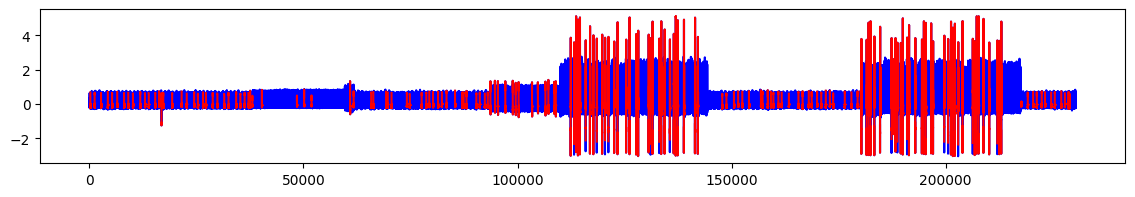

In [2]:
## Select File
data_name = 'ecg'
dir = os.getcwd() + f'/data/synthetic/{data_name}/n_drift'
f = '0_ECG_Test_n_d_grad_p0_n8_b50.arff'

data, label = read_arff(f'{dir}/{f}')
data = data.reshape(-1)
label = label.reshape(-1)
plot_anomaly(data, label)

### AnDri (Off) (with parameters)

SW: 20
NM: 0, Tau: 1.8464565512820708, Nu: 0.7437322703193313, M: 0.7731370923636036, STD: 0.35777315297282236
NM: 1, Tau: 1.1596523953994355, Nu: 0.778912129985022, M: 0.5502183414292438, STD: 0.2031446846567306
NM: 2, Tau: 1.6989331660688394, Nu: 0.7791617340308653, M: 0.5668448348415767, STD: 0.3773627770757542
NM: 3, Tau: 1.1403814530159269, Nu: 0.8408757804038639, M: 0.46796352430926785, STD: 0.22413930956888636
NM: 4, Tau: 4.256023604057925, Nu: 0.6221421991352285, M: 1.4152278001632848, STD: 0.9469319346315468
NM: 5, Tau: 5.2873354048113494, Nu: 0.4520926688776741, M: 2.7564733431090263, STD: 0.8436206872341075
NM: 6, Tau: 3.8074146162950986, Nu: 0.2132394911475436, M: 2.49681222413747, STD: 0.43686746405254284
NM: 7, Tau: 7.089115064071669, Nu: 0.6836855566672978, M: 3.2261206143569394, STD: 1.2876648165715767
NM: 8, Tau: 7.619016474738002, Nu: 0.6728810679833048, M: 3.390463611967262, STD: 1.40951762092358
NM: 9, Tau: 9.704847580210314, Nu: 0.7277228844553507, M: 3.95659760566

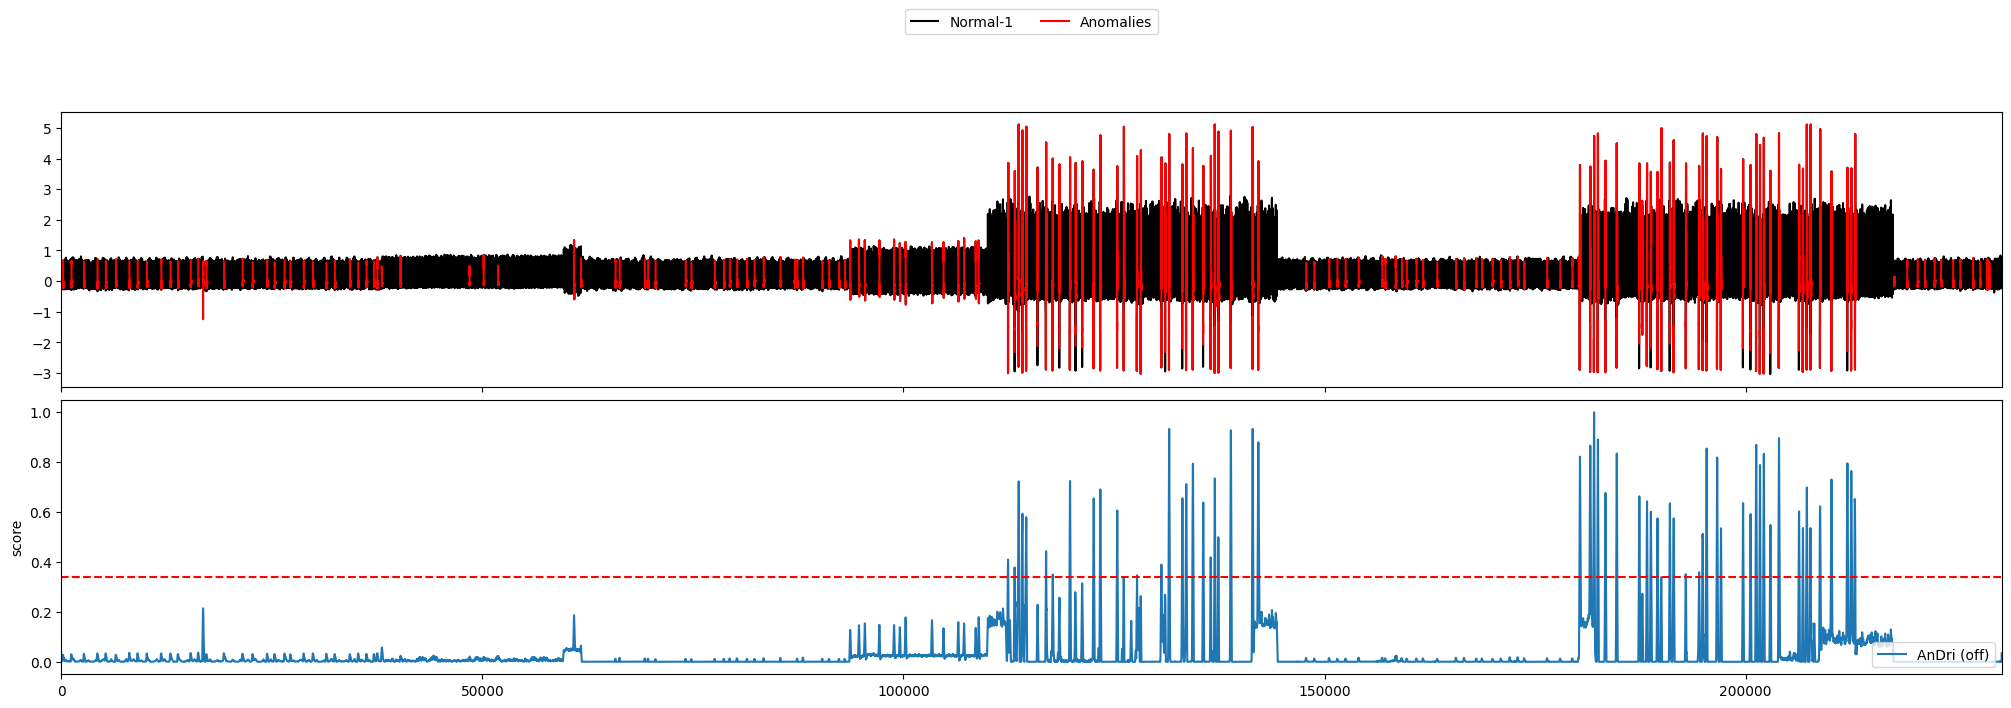

In [11]:
slidingWindow = find_length(data[:10000])
if data_name == 'elec': slidingWindow = 48
if data_name == 'weather': slidingWindow = 24

scores, slabels = [], []
normalize= 'zero-mean'  # default
kadj=1                  # default
nm_len=2                # default
overlap=0               # default
min_size = 0.01         # default for offline
max_W = 20
train_len = 0.2* len(data)
stepwise=True           # default

## Offline
modelName='AnDri (off)'
start_t = time()
clf = A2D2(pattern_length=slidingWindow, normalize=normalize, linkage_method='ward', th_reverse=5, kadj=kadj, nm_len=nm_len, overlap=overlap, max_W=max_W, eta=1)
x = data
clf.fit(x, y=label, online=False, training=True, training_len=int(train_len), stump=False, stepwise=stepwise, min_size=min_size)

end_t = time()

print('AnDri (off): Done (takes)', end_t - start_t)
score = clf.scores

## For fair comparison (To be moved into a2d2.py)
score = MinMaxScaler(feature_range=(0,1)).fit_transform(score.reshape(-1,1)).ravel()
if len(score) < len(x):
    score = np.append(score, np.ones(len(x)-len(score))*np.mean(score))

scores.append(score)
slabels.append('AnDri (off)')

plotFigRev(data, label, scores, slabels, slidingWindow, plotRange=None, fname='temp.png')

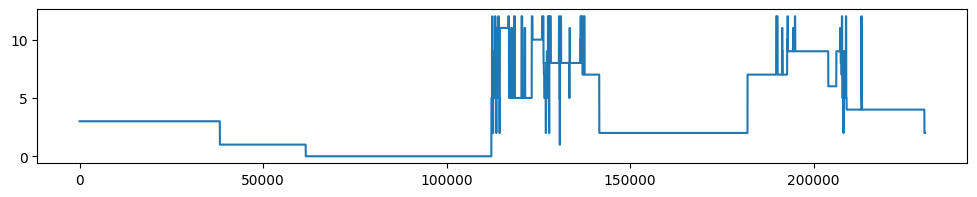

In [12]:
## Cluster info. (for each point)
plt.figure(figsize=(12,2))
# plt.plot(clf.cl_s[110000:130000])
plt.plot(clf.cl_s)

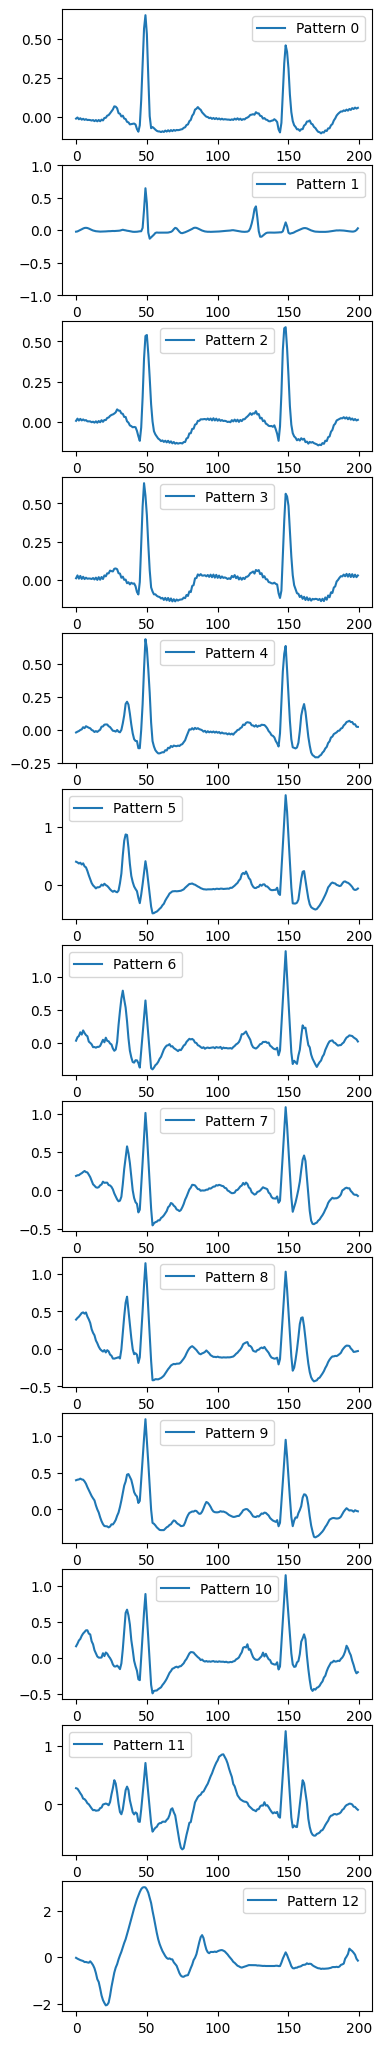

In [13]:
fig, ax = plt.subplots(len(clf.NMs),1, figsize=(4, 2*len(clf.NMs)))
for i, NM in enumerate(clf.NMs):
    ax[i].plot(NM.subseq, label=f'Pattern {i}')
    ax[i].legend()
    ax[1].set_ylim([-1,1])
    

SW: 20
NM: 0, Tau: 1.145291977053428, Nu: 0.7586427512552758, M: 0.5162866773543927, STD: 0.20966843323301176
NM: 1, Tau: 1.1403814530159269, Nu: 0.8408757804038639, M: 0.46796352430926785, STD: 0.22413930956888636
Train: 46080 vs 46031 start: 46080
START: 2, 461
[55780], NM 1, tau: 1.15 (M: 0.5162866773543927, STD: 0.20966843323301176) vs. 2.2628605295221655, (M: 0.5657151323805414, STD: 0.5657151323805414)
[59280], NM 1, tau: 1.15 (M: 0.5162866773543927, STD: 0.20966843323301176) vs. 2.228967235564235, (M: 0.5572418088910588, STD: 0.5572418088910588)
[<-- Inactive]: NM 1 = 0.7246620076672369/0.8408757804038639, at 61380
[--> Active]: NM 1 = 0.8602750619854431/0.8408757804038639, at 62780
[64780], NM 1, tau: 1.15 (M: 0.5162866773543927, STD: 0.20966843323301176) vs. 4.069501856442613, (M: 1.0173754641106532, STD: 1.0173754641106532)
[67480], NM 1, tau: 1.15 (M: 0.5162866773543927, STD: 0.20966843323301176) vs. 4.138376678839794, (M: 1.0345941697099486, STD: 1.0345941697099486)
SW: 20


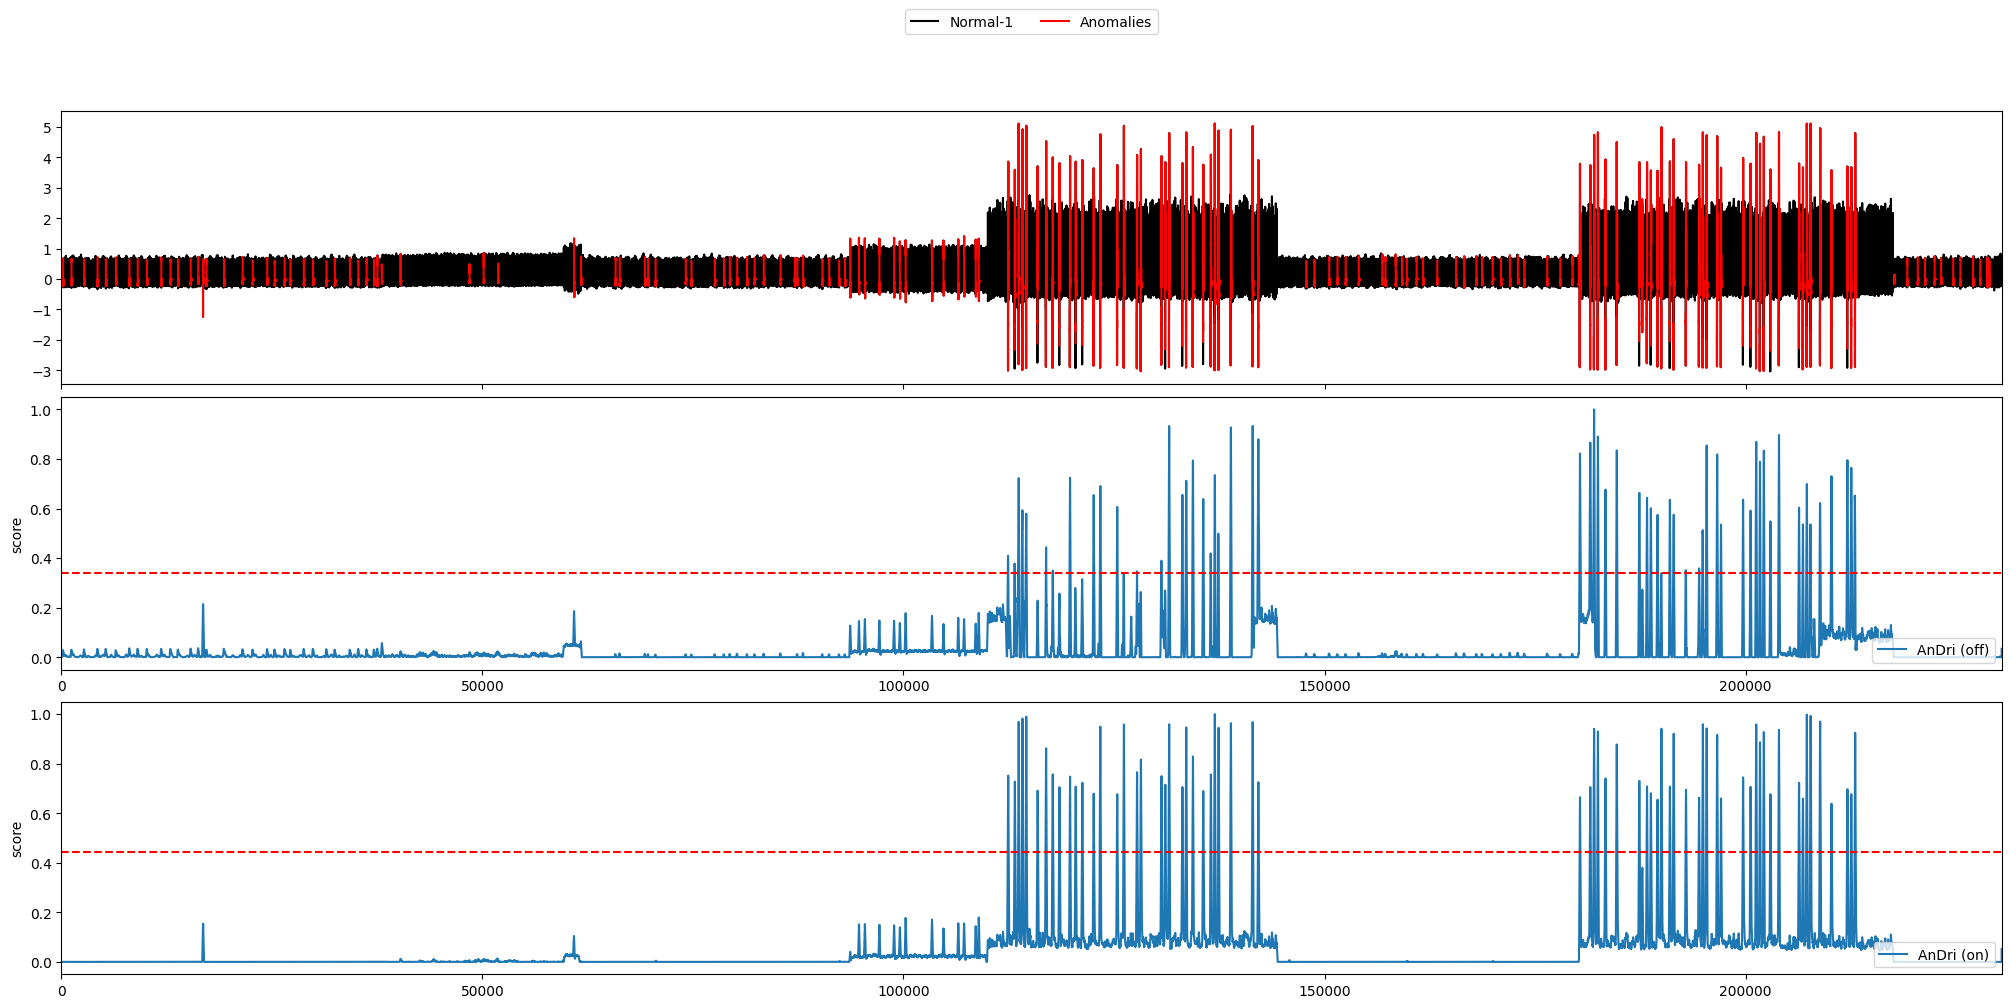

In [14]:
min_on = 0.025  ## for online
delta = max_W*slidingWindow

modelName='AnDri (on)'
start_t = time()
clf = A2D2(pattern_length=slidingWindow, normalize=normalize, linkage_method='ward', th_reverse=5, kadj=kadj, nm_len=nm_len, overlap=overlap, max_W=max_W, eta=1, REVISE_SCORE=True)
x = data

clf.fit(x, y=label, online=True, training=True, training_len=int(train_len),  delta=delta, stump=False, stepwise=stepwise, min_size=min_on)
end_t = time()
if len(clf.scores) ==0 :
    num_min_cl_on = 0
    scores.append(np.zeros(len(x)))
else:
    num_min_cl_on = len(clf.listcluster[clf.listcluster == -1])
    score = clf.scores
    score = MinMaxScaler(feature_range=(0,1)).fit_transform(score.reshape(-1,1)).ravel()
    if len(score) < len(x):
        score = np.append(score, np.ones(len(x)-len(score))*np.mean(score))
    scores.append(score[:len(x)])
slabels.append('AnDri (on)')

print('AnDri (on) -Done (takes)', end_t - start_t)
plotFigRev(data, label, scores, slabels, slidingWindow, plotRange=None, fname='temp.png')